# Libraries need to install

In [ ]:
!sudo apt-get install libleptonica-dev 
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!pip install tesseract
!pip install tesseract-ocr
!pip install pytesseract
!pip install pdf2image
!sudo apt-get install poppler-utils

In [ ]:
!unzip /content/ocr-document_final.zip

# Setup the python enviroment

In [3]:
import os
os.environ['PYTHONPATH'] ="/content/ocr-document_final"
!export PYTHONPATH="/content/ocr-document_final"

In [4]:
cd /content/ocr-document_final

/content/ocr-document_final


# OCR classs

In [5]:
from pdf2image import convert_from_path
from tools.utils import align_images , text_processing , mark_region
from collections import namedtuple
import pytesseract
import argparse
import imutils
import cv2
import numpy as np
from PIL import Image
import re
import pandas as pd

In [6]:
class OCR_Document():

  def __init__(self , pdf_file , template_file , csv_file=None) :

    self.pdf_file = pdf_file
    self.template_file = template_file
    self.csv_file = csv_file
    self.OCRLocation = namedtuple("OCRLocation", ["id", "bbox","filter_keywords"])

    # define the locations of each area of the document we wish to OCR
    self.OCR_LOCATIONS = [
        self.OCRLocation("service_bill", (110, 5, 400 , 150),
            ["Service Bill", "CHARLOTTE" ]),
        self.OCRLocation("bill summary", (108,147 , 382 , 209 ),
            ["Bill Summary", "Bill Date","Due Date","Past Due","New Charges","Total Amount Due"]),
        self.OCRLocation("details", (639, 14 , 450, 135),
            ["Name", "Mailing Address","Service Address"]),
        self.OCRLocation("amount", (487, 355 , 600 , 246 ),
            [ "PRVIOUS BALANCE","PAYMENTS","NEW CHARGES" ,"TOTAL AMOUNT DUE"]),
        self.OCRLocation("account number", (671, 150 , 163 , 61 ),
            [ "Account Number"]),
        self.OCRLocation("parcel", (882,150, 184 , 66 ),
            [ "Parcel"]),
        self.OCRLocation("meter_readings", (26, 356 , 470 , 97 ),
            [ "MeterNo","PreviousRead","CurrentRead" ,"Ccf" ,"Service"]) ]

  def read_pdf(self):
    
    pdfs = self.pdf_file
    pages = convert_from_path(pdfs, 130 , fmt="jpeg")

    self.invoices = []
    for page in pages:
        page = Image.fromarray(np.array(page)[:700 , : , :].astype(np.uint8))
        self.invoices.append(page)

  def run_ocr(self):

    self.read_pdf()

    invoice_list =[]

    template = cv2.imread(self.template_file) 

    for i_invoice in self.invoices:
      image = np.array( i_invoice )

      invoice = self.compute(image , template)
      invoice_list.append(invoice)

    self.invoice_df = pd.DataFrame(invoice_list)

    return self.invoice_df

  def update_csv(self):

    if(self.csv_file !=None):
      df_old = pd.read_csv (self.csv_file , index_col=0)
      concat_df = df_old.append(self.invoice_df, ignore_index=True)
      concat_df.to_csv(self.csv_file, sep=',', encoding='utf-8')

    else:
      self.csv_file = "invoice_data.csv"
      self.invoice_df.to_csv(self.csv_file , sep=',', encoding='utf-8')

  def cleanup_text(self,text):

    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()



  def compute(self , image , template):

    invoice_dict = dict()

    # align the images
    print("[INFO] aligning images...")
    aligned_bgr = align_images(image, template)

    i_index , line_info = mark_region(image , template)

    # initialize a results list to store the document OCR parsing results
    print("[INFO] OCR'ing document...")
    parsingResults = []
    # loop over the locations of the document we are going to OCR
    for loc in self.OCR_LOCATIONS:
      # extract the OCR ROI from the aligned image
      if( (loc.id=="amount") or (loc.id=="meter_readings")):
        (x,y,w,h) = loc.bbox
        x_right = x+w
        y_bottom = y+h
        min_error = np.inf
        if(i_index != None):
          i_left , i_right =  line_info[i_index] 

          if(loc.id =="amount"):
            x_out , y_out , w_out , h_out = x , y , i_right[0] - x , i_right[1] - y	 +50

          if(loc.id=="meter_readings"):
            x_out , y_out , w_out , h_out = x , y , w , i_right[1] - y
        else:
          x_out , y_out , w_out , h_out = x , y , w , h

      else:
        (x_out, y_out, w_out, h_out) = loc.bbox
      roi = aligned_bgr[y_out:y_out + h_out, x_out:x_out + w_out]
      # OCR the ROI using Tesseract
      rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
      edges = cv2.Canny(rgb,180,200)
      #ret,thresh1 = cv2.threshold(rgb,100,255,cv2.THRESH_BINARY)
      edges =np.concatenate([ edges[:,:,np.newaxis] for i in range(3)], axis=-1)
      dst = cv2.addWeighted(rgb,0.7,edges,0.2,0)
      text = pytesseract.image_to_string(dst,  config='--psm 6 --oem 3  -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyz')
    
      # break the text into lines and loop over them
      for line in text.split("\n"):
        # if the line is empty, ignore it
        if len(line) == 0:
          continue

        # convert the line to lowercase and then check to see if the
        # line contains any of the filter keywords (these keywords
        # are part of the *form itself* and should be ignored)
        lower = line.lower()
        count = sum([lower.count(x) for x in loc.filter_keywords])

        # if the count is zero than we know we are *not* examining a
        # text field that is part of the document itself (ex., info,
        # on the field, an example, help text, etc.)
        if count == 0:
          # update our parsing results dictionary with the OCR'd
          # text if the line is *not* empty
          parsingResults.append((loc, line))

    # initialize a dictionary to store our final OCR results
    results = {}

    # loop over the results of parsing the document
    for (loc, line) in parsingResults:
      # grab any existing OCR result for the current ID of the document
      r = results.get(loc.id, None)

      # if the result is None, initialize it using the text and location
      # namedtuple (converting it to a dictionary as namedtuples are not
      # hashable)
      if r is None:
        results[loc.id] = (line, loc._asdict())

      # otherwise, there exists a OCR result for the current area of the
      # document, so we should append our existing line
      else:
        # unpack the existing OCR result and append the line to the
        # existing text
        (existingText, loc) = r
        text = "{}\n{}".format(existingText, line)

        # update our results dictionary
        results[loc["id"]] = (text, loc)

    # loop over the results
    for (locID, result) in results.items():
      # unpack the result tuple
      (text, loc) = result

      # extract the bounding box coordinates of the OCR location and
      # then strip out non-ASCII text so we can draw the text on the
      # output image using OpenCV
      (x, y, w, h) = loc["bbox"]
      clean = self.cleanup_text(text)
      dict_out = text_processing(loc , text)
      invoice_dict.update(dict_out)
      print(dict_out)

      cv2.rectangle(aligned_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)



    # show the input and output images, resizing it such that they fit
    # on our screen
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,20))
    plt.imshow(imutils.resize(image, width=700))
    plt.imshow(imutils.resize(aligned_bgr, width=700))
    plt.show()

    return invoice_dict

  


In [7]:
ocr = OCR_Document(pdf_file = "/content/ocr-document_final/doc00668420201026091329.pdf" ,
                   template_file="/content/ocr-document_final/template/Page_3.jpg")
#csv_file ="/content/ocr-document/submission.csv"

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CHARLOTTE,'}
{'Due Date': '4102/20', 'Past Due': '$0.00', 'New Charges': '$57.28', 'Total Amount': '$57.28'}
{'Name': 'MARC H SILVERMAN', 'Mailing Address': '6707 FAIRVIEW RD SUITE C / __ CHARLOTTE NC 28210', 'Service Address': '9410 D DUCKS LN / CHARLOTTE NC 28273,'}
{'Previous Balance': '$33.92', 'Payments': '33.92', 'Water, Fire Line': '57.28', 'Total New Charges': '57.28', 'Total Amount Due': '$57.28'}
{'Account Number': '20501-178011'}
{'Parcel': '20112446'}
{'Meter 1': '107249967', 'Preivous Date 1': 'Sep 02.', 'Previous Read 1': '880', 'Current Date 1': 'Oct 02', 'Current Read 1': '889'}


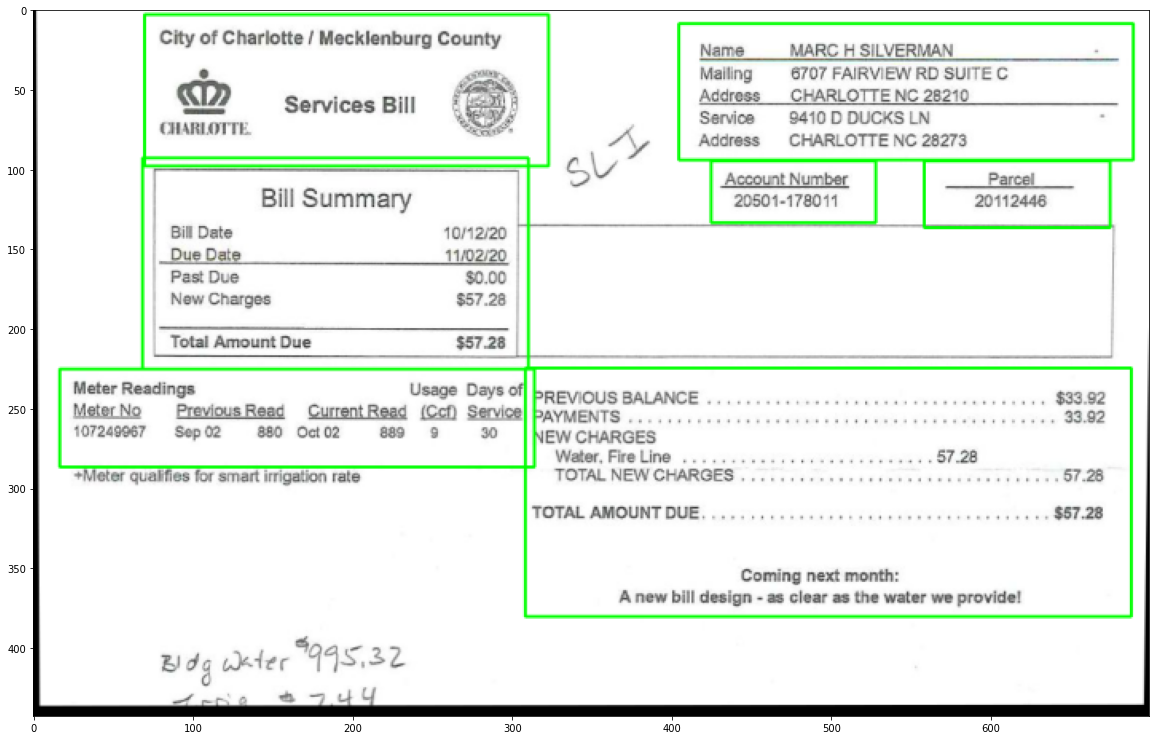

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CHARLOTTE.'}
{'Bill Date': '10/12/20.', 'Due Date': '11/02/20', 'Past Due': '$0.00', 'New Charges': '$7.44', 'Total Amount': '$7.44'}
{'Name': 'MARG H SILVERMAN', 'Mailing Address': '6707 FAIRVIEW RD APT C / CHARLOTTE NO 28210', 'Service Address': '9440 D DUCKS LN / CHARLOTTE NC 28273'}
{'Previous Balance': '$7.44', 'Payments': '7.44', 'Water Fees (fixed and availability) ;': '7.44', 'Total New Charges': 'TA,', 'Total Amount Due': '$7.44'}
{'Account Number': '20499-178011'}
{'Parcel': '20112446'}
{'Meter 1': '107250450+', 'Preivous Date 1': 'Sep 02', 'Previous Read 1': '0', 'Current Date 1': 'Octo2', 'Current Read 1': '0'}


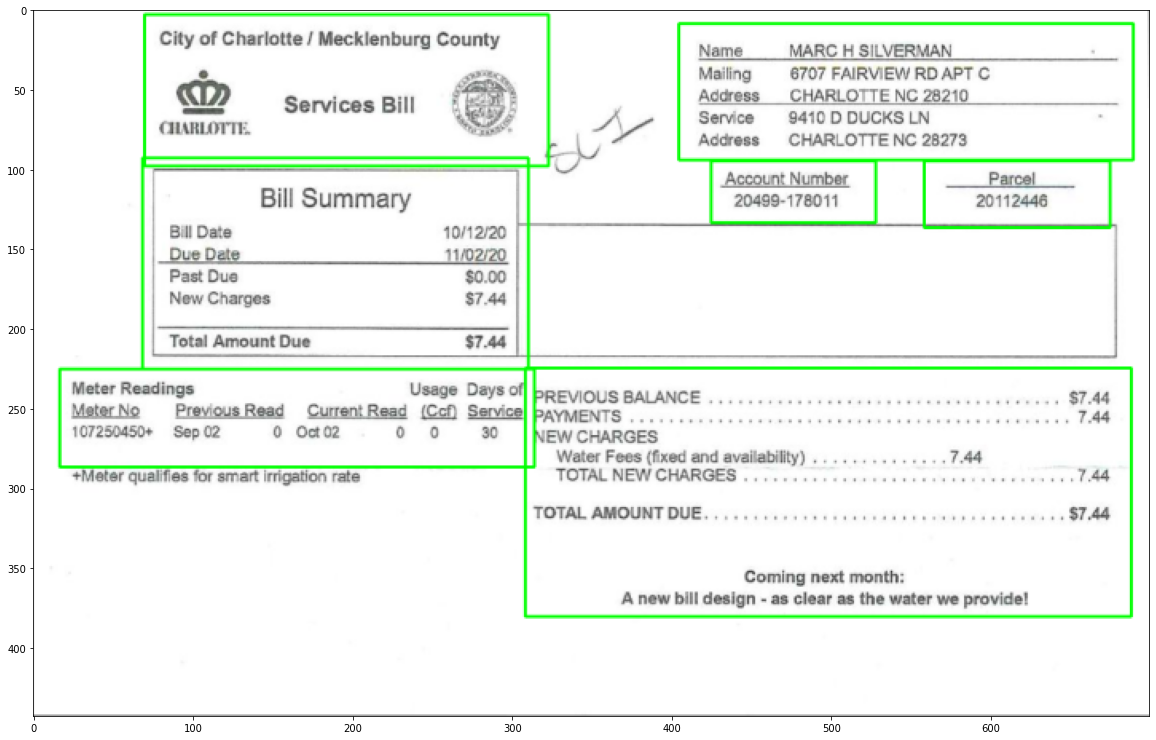

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CHARLOTTE.'}
{'Bill Date': 'if', 'Due Date': '41/02/20', 'Past Due': '$0.00', 'New Charges': '$256.34', 'Total Amount': '$256.34'}
{'Name': 'SILVER LAKE', 'Mailing Address': '6707 FAIRVIEW RD APT C / __ CHARLOTTE NC 28210 _', 'Service Address': '9410 D DUCKS LN / CHARLOTTE NC 28273,'}
{'Previous Balance': '$353.66', 'Payments': '353.66', 'Water Usage ’ ‘': 'reo', 'Sewer Usage ($5.19 per Ccf of water usage)': '81.44', 'Water Fees (fixed and availability) 1': '14.64', 'Sewer Fees (fixed and availablity)': '73.86', 'Storm Water Fee': '419.29', 'Total New Charges': '256.34', 'Total Amount Due': '$256.34'}
{'Account Number': '20500-17801'}
{'Parcel': '20112446'}
{'Meter 1': '209508286', 'Preivous Date 1': 'Sep02', 'Previous Read 1': '2346', 'Current Date 1': 'Oci02', 'Current Read 1': '2362'}


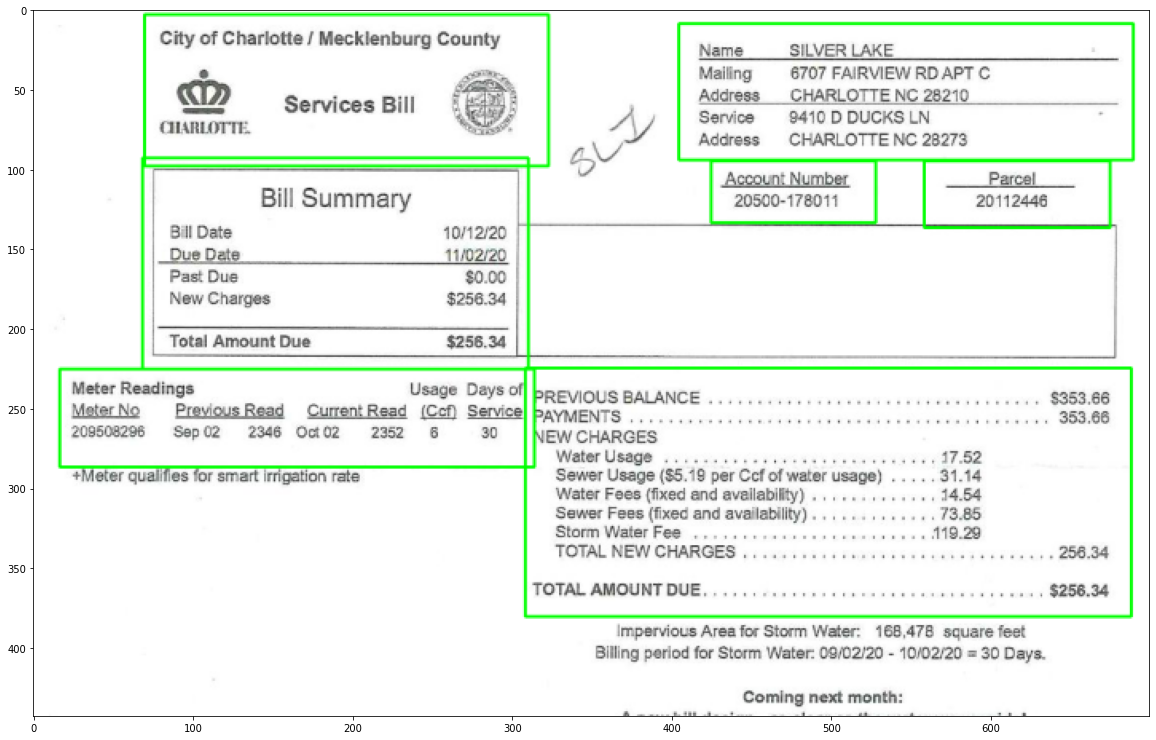

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CHARLOTTE:'}
{'Bill Date': '40/12/20', 'Due Date': '11/02/20', 'Past Due': '$0.00', 'New Charges': '$397.26', 'Total Amount': '$397.26'}
{'Name': 'SILVERLAKE', 'Mailing Address': '6707 FAIRVIEW RD SUITE C / CHARLOTTE NC 28210', 'Service Address': '9405 D DUCKS LN / CHARLOTTE NC 28273'}
{'Previous Balance': '$464.08', 'Payments': '454.03', 'Water Usage :': '70.08', 'Sewer Usage (85.19 per Ccf of water usage)': '124.56', 'Water Fees (fixed and availability)': '14.54', 'Sewer Fees (fixed and availability)': '73.85', 'Storm Water Fee': '414.28', 'Total New Charges': '397.26', 'Total Amount Due': '$397.26'}
{'Account Number': '201807-178010'}
{'Parcel': '20112443'}
{'Meter 1': '16942242', 'Preivous Date 1': 'Sep02', 'Previous Read 1': '2983', 'Current Date 1': 'Octo2', 'Current Read 1': '2057'}


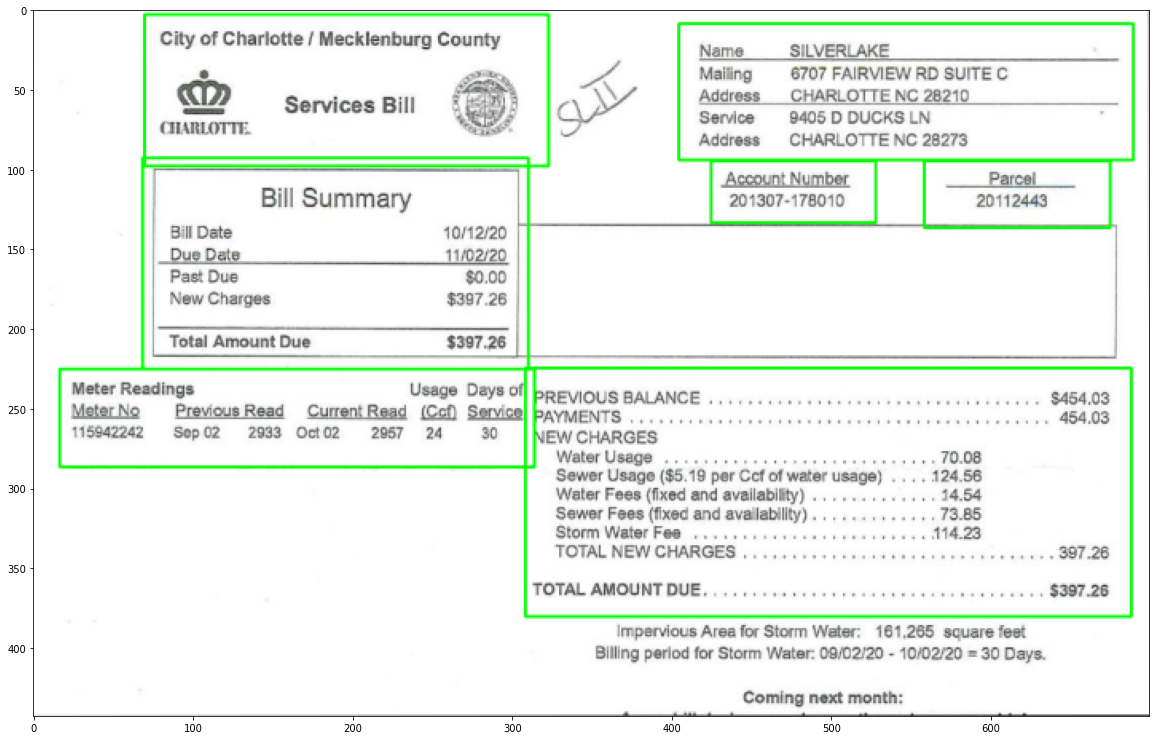

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CUARLOTTE'}
{'Bill Date': '40/12/20', 'Due Date': '44/02/20', 'Past Due': '$0100', 'New Charges': '$267.33', 'Total Amount': '$267.33'}
{'Name': 'SILVERLAKE II', 'Mailing Address': '6707 FAIRVIEW RD SUITE C / __ CHARLOTTE NC 26210', 'Service Address': '9347 D DUCKS LN / CHARLOTTE NC 28273'}
{'Previous Balance': '$283.55,', 'Payments': '283.55', 'Water Usage': '44.68', 'Sewer Usage ($5.19 per Ccf of water usage)': '20.76', 'Water Fees (fixed and availability)': '26.24', 'Sewer Fees (fixed and availability)': '73.85', 'Storm Water Fee': '135.83', 'Total New Charges': '267,38', 'Total Amount Due': '$267.33'}
{'Account Number': '613280-192016'}
{'Parcel': '20112448'}
{'Meter 1': '460112439', 'Preivous Date 1': 'Sep02.', 'Previous Read 1': '1377', 'Current Date 1': 'Octo2', 'Current Read 1': '1281', 'Meter 2': '209701344+', 'Preivous Dat

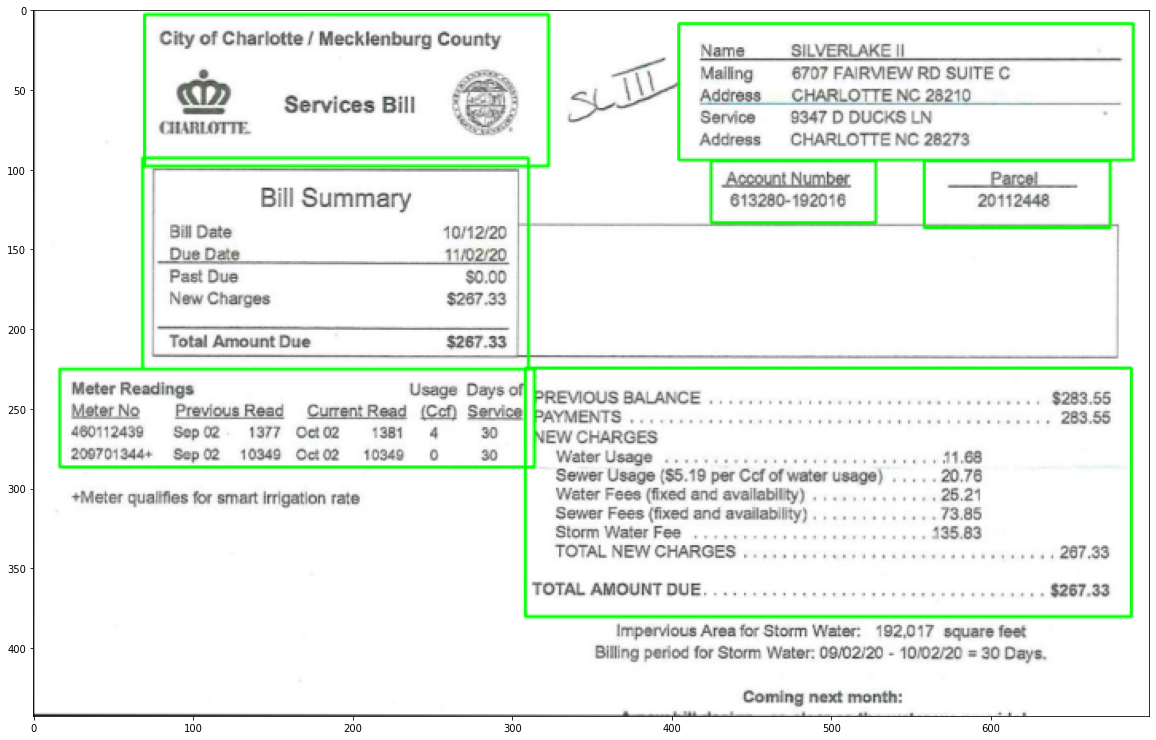

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County GURLOTTE.'}
{'Bill Date': '10/11/20', 'Due Date': '41/04/20', 'Past Due': '$0.00', 'New Charges': '$129.84', 'Total Amount': '$129.84'}
{'Name': 'SILVERLAKE', 'Mailing Address': '6707 FAIRVIEW RD SUITE C / _ CHARLOTTE NC 28210', 'Service Address': '9348 D DUCKS LN / © CHARLOTTE NC 28273'}
{'Previous Balance': '$129.84', 'Payments': '129.84', 'Storm Water Fee': '129.84', 'Total New Charges': '129.84', 'Total Amount Due': '$129.84'}
{'Account Number': '201307-263012'}
{'Parcel': '20412447'}
{}


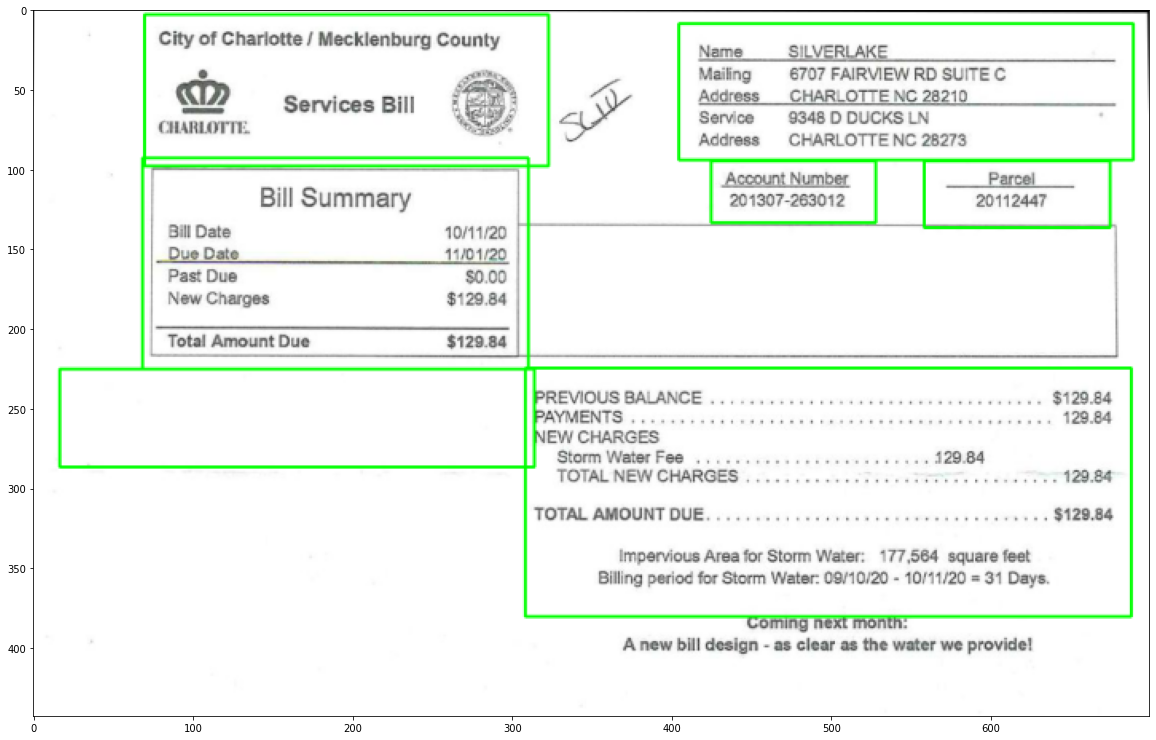

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CHARLOTTE.'}
{'Bill Date': '10/12/20', 'Due Date': '102/20', 'Past Due': '$0.00', 'New Charges': '$181.38', 'Total Amount': '$161.38'}
{'Name': 'MARC SILVERMAN', 'Mailing Address': '6707 FAIRVIEW RD SUITE C / CHARLOTTE NG 28210', 'Service Address': '9348 D DUCKS LN / CHARLOTTE NC 28273'}
{'Previous Balance': '$169.49', 'Payments': '168.49', 'Water Usage': '26.28', 'Sewer Usage ($5.19 per Cef of water usage)': '46.74', 'Water Fees (fixed and availability)': '14.54', 'Sewer Fees (fixed and availability)': '73,85', 'Total New Charges': '161.38', 'Total Amount Due': '$161.38'}
{'Account Number': '710543-196412'}
{'Parcel': '20112447'}
{'Meter 1': '431638363', 'Preivous Date 1': 'Sep02', 'Previous Read 1': '1453', 'Current Date 1': 'Oc02', 'Current Read 1': '1482'}


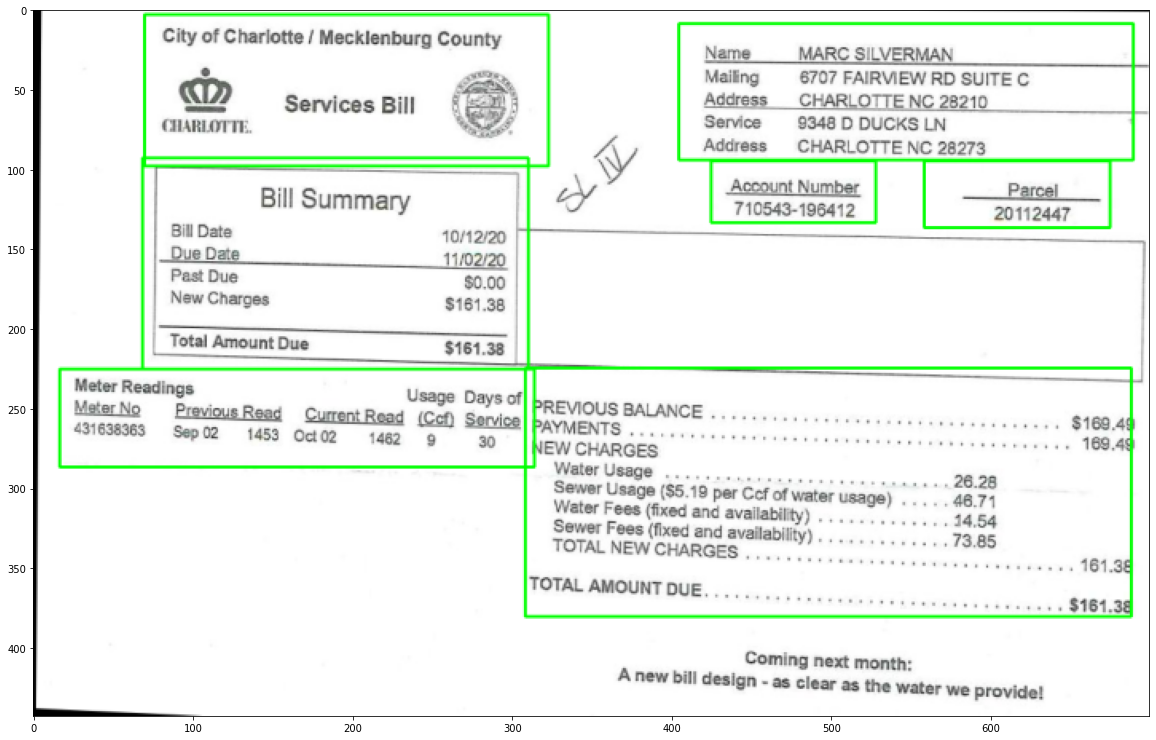

[INFO] aligning images...
[INFO] loading images...
[INFO] aligning images...
[INFO] OCR'ing document...
{'Heading': 'City of Charlotte / Mecklenburg County CHARLOTTE.'}
{'Bill Date': '10/12/20', 'Due Date': '44/02/20', 'Past Due': '$0.00', 'New Charges': '$429.89', 'Total Amount': '$429.89'}
{'Name': 'SILVERLAKE VI LLC', 'Mailing Address': '6707 FAIRVIEW RD SUITE C / _ CHARLOTTE NC 28210', 'Service Address': '9810 D DUCKS LN / © CHARLOTTE NC 28273'}
{'Previous Balance': '$340.68', 'Payments': '340,68', 'Water Usage': '67.16', 'Sewer Usage (85.19 per Ccf of water usage)': '419.37', 'Water Fees (fixed and availability)': '21.98', 'Sewer Fees (fixed and availability)': '73.86', 'Storm Water Fee': 'cuore', 'Total New Charges': '429.88', 'Total Amount Due': '$429.89'}
{'Account Number': '232555-208669'}
{'Parcel': '201412444'}
{'Meter 1': '209304053', 'Preivous Date 1': 'Sep 02', 'Previous Read 1': '3091', 'Current Date 1': 'Oct 02', 'Current Read 1': '3114', 'Meter 2': '107250448', 'Preivo

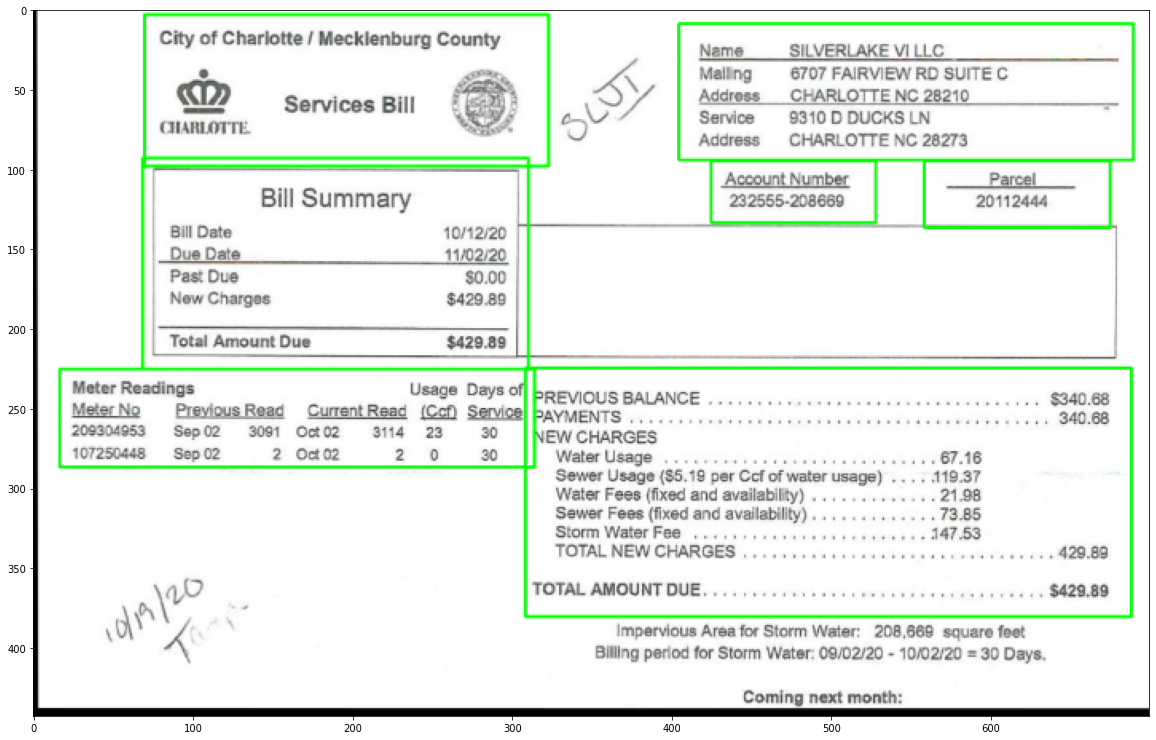

In [8]:
invoice = ocr.run_ocr()

In [10]:
ocr.update_csv()

In [ ]:
!zip -r final_ocr.zip //content/ocr-document_final